In [ ]:
import time
import copy
import random
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Agent Class:

In [ ]:
class Agent:

  def __init__(self, start: tuple, goal: tuple, real_stage, view_range=2):
      self.x = start[0]
      self.y = start[1]
      self.goal = goal
      self.view_range = view_range
      self.explored_stage = np.full_like(real_stage, -1)
      self.explored_stage[self.x, self.y] = 0
      self.agent_view(real_stage)
      self.start_time = time.time()

  def agent_view(self, real_stage):
    """ Refreshes the explored map of the agent (sees up, down, left, right). """
    up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
    for i in range(self.view_range):
      if self.x > i:  # checks up
        tmp_x = self.x - i - 1
        if not up_obs:  # stops if it sees obstacle
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            up_obs = True
        if self.y > i and not upleft_obs:  # up-left
          if not upleft_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              upleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # up-right
          if not upright_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              upright_obs = True

      if self.x < len(real_stage) - i - 1:  # checks down:
        tmp_x = self.x + i + 1
        if not down_obs:
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            down_obs = True
        if self.y > i:  # down-left
          if not downleft_obs:
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              downleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # down-right
          if not downright_obs:
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              downright_obs = True

      if self.y > i and not left_obs:  # left (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y - i - 1)] = real_stage[(self.x, self.y - i - 1)]
        if real_stage[(self.x, self.y - i - 1)]:
          left_obs = True

      if self.y < len(real_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y + i + 1)] = real_stage[(self.x, self.y + i + 1)]
        if real_stage[(self.x, self.y + i + 1)]:
          right_obs = True

    self.explored_stage[self.explored_stage == 2] = 0

  def check_goal(self):
    if (self.x, self.y) == self.goal:
      return True
    return False

A* Algorithm (source [here.](https://pypi.org/project/python-astar/)):

In [ ]:
"""
Python-astar - A* path search algorithm
"""

class Tile:
    """A tile is a walkable space on a map."""
    distance = 0
    came_from = None

    def __init__(self, x, y, weight=1):
        self.x = x
        self.y = y
        self.weight = 1
        assert (self.x is not None and self.y is not None)

    def update_origin(self, came_from):
        """Update which tile this one came from."""
        self.came_from = came_from
        self.distance = came_from.distance + self.weight

    def __eq__(self, other):
        """A tile is the same if they have the same position"""
        return (other and self.x == other.x and self.y == other.y)

    def __lt__(self, other):
        """We want the shortest distance tile to find the happy path.
        This is used by min() so we can just compare them :)
        """
        return (self.distance + self.weight <= other.distance)

    def __hash__(self):
        """We need this so we can use a set()"""
        return hash(str(self))

    @property
    def pos(self):
        """a (x, y) tuple with position on the grid"""
        return (self.x, self.y)

    def __str__(self):
        return str(self.pos)

    def __repr__(self):
        return str(self)


class AStar:
    """The A Star (A*) path search algorithm"""

    def __init__(self, world, coverage_mode: bool = False):
        world2 = copy.deepcopy(world)
        world2[world2 == -1] = 0
        if coverage_mode: # coverage_mode == different goals.
          world2[world2 == 2] = 1 # astar takes agents into account.
        else:
          world2[world2 == 2] = 0
        self.world = world2

    def search(self, start_pos, target_pos):
        """A_Star (A*) path search algorithm"""
        start = Tile(*start_pos)
        self.open_tiles = set([start])
        self.closed_tiles = set()

        # while we still have tiles to search
        while len(self.open_tiles) > 0:
            # get the tile with the shortest distance
            tile = min(self.open_tiles)
            # check if we're there. Happy path!
            if tile.pos == target_pos:
                return self.rebuild_path(tile)
            # search new ways in the neighbor's tiles.
            self.search_for_tiles(tile)

            self.close_tile(tile)
        # if we got here, path is blocked :(
        return None

    def search_for_tiles(self, current):
        """Search for new tiles in the maze"""
        for other in self.get_neighbors(current):
            if self.is_new_tile(other):
                other.update_origin(current)
                self.open_tiles.add(other)

            # if this other has gone a farthest distance before
            #   then we just found a new and shortest way to it.
            elif other > current:
                other.update_origin(current)
                if other in self.closed_tiles:
                    self.reopen_tile(other)

    def get_neighbors(self, tile):
        """Return a list of available tiles around a given tile"""
        min_x = max(0, tile.x - 1)
        max_x = min(len(self.world)-1, tile.x + 1)
        min_y = max(0, tile.y - 1)
        max_y = min(len(self.world[tile.x])-1, tile.y + 1)

        available_tiles = [
            (min_x, tile.y),
            (max_x, tile.y),
            (tile.x, min_y),
            (tile.x, max_y),
        ]
        neighbors = []
        for x, y in available_tiles:
            if (x, y) == tile.pos:
                continue

            if self.world[x][y] == 0:
                neighbors.append(Tile(x, y))

        return neighbors

    def rebuild_path(self, current):
        """Rebuild the path from each tile"""
        self.last_tile = current
        path = []
        while current is not None:
            path.append(current)
            current = current.came_from
        path.reverse()
        # return a list with tuples
        return [tile.pos for tile in path]

    def is_new_tile(self, tile):
        """Check if this is a proviously unknown tile"""
        return (
            tile not in self.open_tiles
            and tile not in self.closed_tiles
        )

    def reopen_tile(self, tile):
        """Reinstate a tile in the open list"""
        self.closed_tiles.remove(tile)
        self.open_tiles.add(tile)

    def close_tile(self, tile):
        """Remove tile from open_tiles, as we are done testing it"""
        self.open_tiles.remove(tile)
        self.closed_tiles.add(tile)

Create a stage with obstacles (1) and free path (0).

In [ ]:
def generate_stage(rows: int, cols: int, obs_prob = 0.2):

  # generate obstacles with obs_prob probability
  num_obstacles = int(rows * cols * obs_prob)

  stage = np.full((rows, cols), 0)

  # Set 1s at random positions for the specified percentage
  indices = np.random.choice(rows * cols, num_obstacles, replace=False)
  stage.flat[indices] = 1

  return stage

 Creates the "explored" stage, which at the start everything is not explored (-1) and put the agents there (2).

In [ ]:
def generate_agents(real_stage, num_agents: int = 1, view_range: int = 2, coverage_mode: bool = False):

  agents = []

  if num_agents <= 0:
    num_agents = 1

  zero_coordinates = list(zip(*np.where(real_stage == 0)))
  goal = random.choice(zero_coordinates)
  zero_coordinates.remove(goal)
  # Create the "explored" stage
  for _ in range(num_agents):
    if zero_coordinates:
      start = random.choice(zero_coordinates)
      zero_coordinates.remove(start)
      agents.append(Agent((start[0], start[1]), (goal[0], goal[1]), real_stage, view_range))
      if coverage_mode: # puts different goals
        goal = random.choice(zero_coordinates)
        zero_coordinates.remove(goal)
    else:
      break

  return agents

Function to concat all agents explored stages (returns the total explored stage):

In [ ]:
def update_total_explored(agents, coverage_mode=False):
  if len(agents) == 0:
    return

  total_explored = np.full(agents[0].explored_stage.shape, -1)

  total_explored[0, :] = 1
  total_explored[-1, :] = 1
  total_explored[:, 0] = 1
  total_explored[:, -1] = 1

  for a in agents:
    total_explored[total_explored == -1] = a.explored_stage[total_explored == -1]
    total_explored[total_explored == 2] = 0

  for a in agents:
    if coverage_mode: # agents never leave the stage when coverage mode.
      total_explored[a.x, a.y] = 2
    elif not a.check_goal():  # if agent has reached goal -> collidable (as if it is removed from the stage).
      total_explored[a.x, a.y] = 2

  # Total explored contains the concats of all agents stages:
  for a in agents:
    a.explored_stage = copy.deepcopy(total_explored)

  return total_explored

Calculates the explored percentage of the concat stage:

In [ ]:
def calculate_expl_percentage(total_explored, last_calc=False):
  if last_calc:
    total_explored = np.where(total_explored == -1, 1, total_explored)  # converts all unexplored to 1s.

  # num_minus_1 = np.sum(total_explored == -1)
  # explored_percentage = 1 - (num_minus_1 / (total_explored.shape[0] * total_explored.shape[1]))

  subarray = total_explored[1:-1, 1:-1] # gets all rows and columns except from first and last.
  num_minus_1 = np.sum(subarray == -1)
  explored_percentage = 1 - (num_minus_1 / (subarray.shape[0] * subarray.shape[1]))
  return explored_percentage

Function to plot the grid/maze:

In [ ]:
def draw_maze(maze, path=None, goal=None):
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    if goal is not None:
        ax.scatter(goal[1], goal[0], color='red', s=100, marker='s')

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

Function for testing astar:

In [ ]:
def move_astar(start_grid, start_agents, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents)
  total_agents = len(agents)
  # print(total_agents)
  avg_eps_time = []
  avg_rounds = []
  num_finish = 0

  rounds = 0
  while any((agent.x, agent.y) != agent.goal for agent in agents):
      rounds+=1
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          if agent.check_goal():
              num_finish += 1
              total_explored = update_total_explored(agents)
              agents.remove(agent)
              avg_rounds.append(rounds)
              continue  # Agent has reached its goal

          path = AStar(agent.explored_stage).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze(agent.explored_stage, path=path)

          if path:
              if agent.explored_stage[path[1]] != 2:
                grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
                agent.x, agent.y = path[1]  # Update agent position
                grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
                # if agent.check_goal():
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents)
      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  for agent in agents:  # gets the time of some finished agents (that have not been counted),
    if agent.check_goal():
      num_finish += 1
      avg_rounds.append(rounds)

  return calculate_expl_percentage(total_explored, False), rounds, np.mean(avg_rounds), np.mean(avg_eps_time), num_finish / total_agents, total_explored

Function to update goals of agents (if they are explored).

In [ ]:
def manhattan_dist(a, unexpl_coords):
  agent_position = (a.x, a.y)
  min_distance = float('inf')
  nearest_point = None
  distances = []
  for coord in unexpl_coords:
      distance = abs(agent_position[0] - coord[0]) + abs(agent_position[1] - coord[1])
      distances.append(distance)
  return distances

In [ ]:
def update_goals(agents, total_explored, start=False):
  """ Function to update the goals of the agents (if they are explored). """
  unexpl_coords = np.argwhere(total_explored == -1)
  if len(unexpl_coords) <= 0:
    return

  for a in agents:
    # r = a.goal[0] == 0 or a.goal[0] == total_explored.shape[0] - 1 or a.goal[1] == 0 or a.goal[1] == total_explored.shape[1] - 1  # is True if goal is at the border.
    # if not start and total_explored[a.goal] == -1 and not r:
    if not start and total_explored[a.goal] == -1:
      continue
    rand_indx = False
    distances = cdist([(a.x, a.y)], unexpl_coords, metric='cityblock')
    # distances = manhattan_dist(a, unexpl_coords)
    indx = np.argmin(distances) # the index of unexplored coords with smallest distance (nearest frontier).
    path = AStar(a.explored_stage, coverage_mode=True).search((a.x, a.y), tuple(unexpl_coords[indx]))
    while path is None:
      distances = np.delete(distances, indx)
      if len(distances) == 0: # or indx >= len(unexpl_coords):
        a.goal = tuple(random.choice(unexpl_coords))
        rand_indx = True
        break
      indx = np.argmin(distances)
      path = AStar(a.explored_stage, coverage_mode=True).search((a.x, a.y), tuple(unexpl_coords[indx]))
    if not rand_indx:
      a.goal = tuple(unexpl_coords[indx])

In [ ]:
def check_real_expl(real_grid, total_explored):
  calculate_expl_percentage(total_explored, True) # converts total_explored unexplored obstacles to 1.
  real = copy.deepcopy(real_grid)
  real = np.where(real == 2, 0, real)
  tot = copy.deepcopy(total_explored)
  tot = np.where(tot == 2, 0, tot)
  tot = np.where(tot == -1, 1, tot)

  false_positions = np.where(np.not_equal(real, tot))[0]
  total_false = np.sum(np.not_equal(real, tot)) / (real_grid.shape[0] * real_grid.shape[1])
  if total_false == 0:
    print("Real == Explored? TRUE")
  else:
    print("Real == Explored? FALSE")
    print("Positions of False values:", false_positions)
    draw_maze(real)
    draw_maze(tot)
  return false_positions, total_false

Function for testing astar (with focus on coverage).

In [ ]:
def move_astar_coverage(start_grid, start_agents, coverage_finish = 1.0, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents, True)
  total_agents = len(agents)
  update_goals(agents, total_explored, True)  # create new goal.

  avg_eps_time = []
  rounds = 0

  # tmp_stages = []

  while calculate_expl_percentage(total_explored) < coverage_finish:
      rounds += 1
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze(agent.explored_stage, path=path)

          if path and len(path) > 1:
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents, True)

      # tmp_stages.append(copy.deepcopy(total_explored))
      # update goals (if agents have explored the goals of another agent):
      update_goals(agents, total_explored)
      avg_eps_time.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          # print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  # re = check_real_expl(start_grid, total_explored)
  # if re[1] != 0:
  #   for m in tmp_stages:
  #     draw_maze(m)

  return calculate_expl_percentage(total_explored, True), rounds, total_explored, np.mean(avg_eps_time)

Manual Examples:

LESS OBSTACLES STAGE


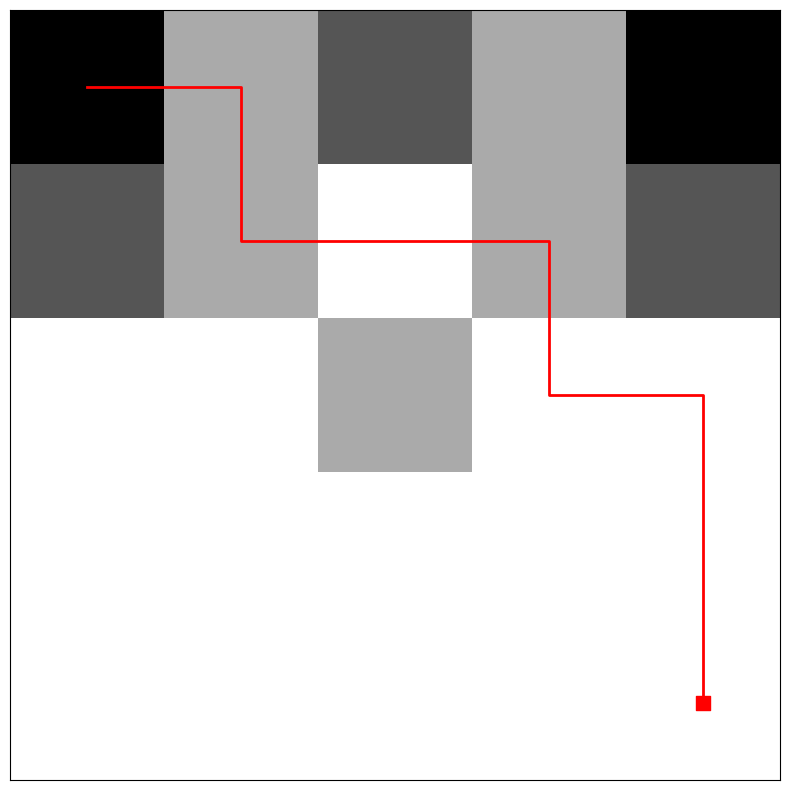

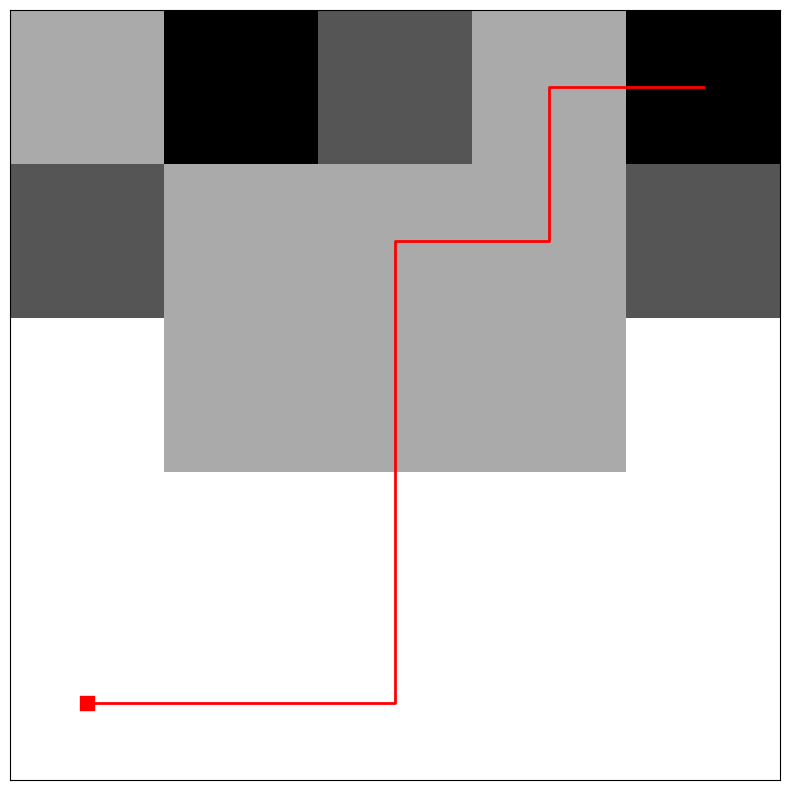

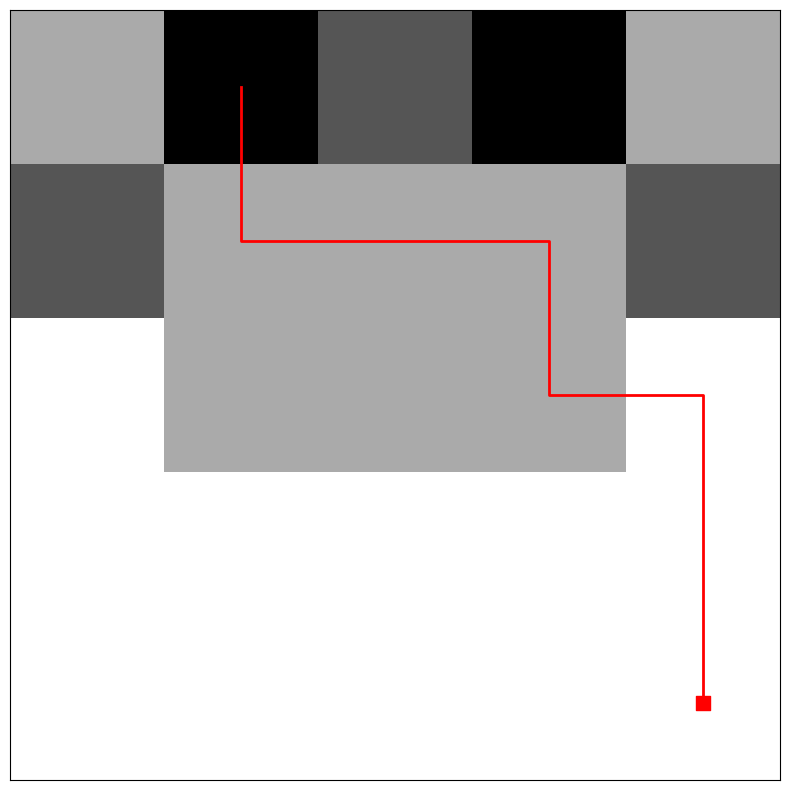

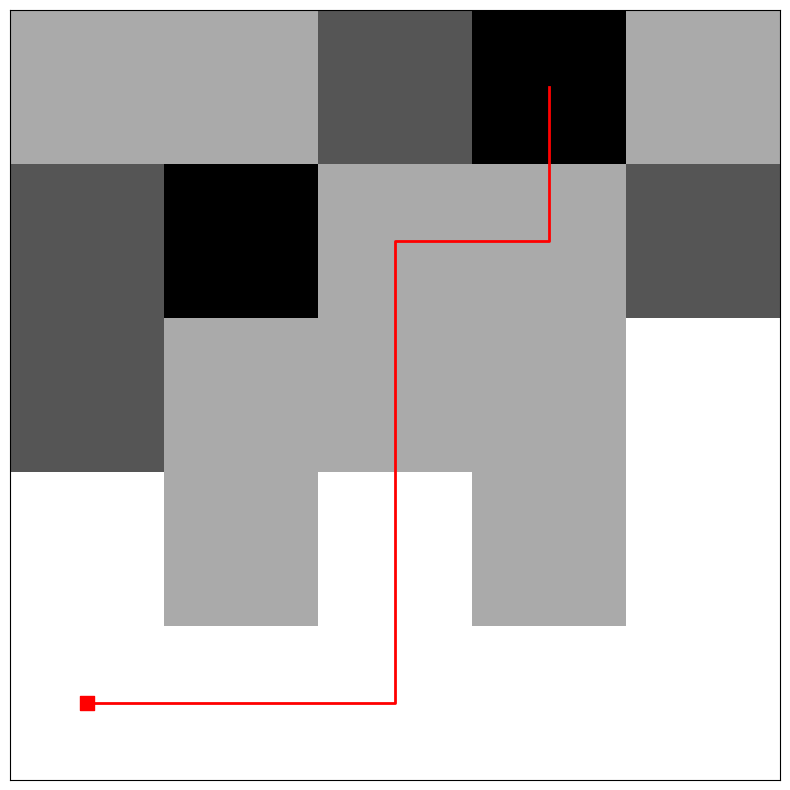

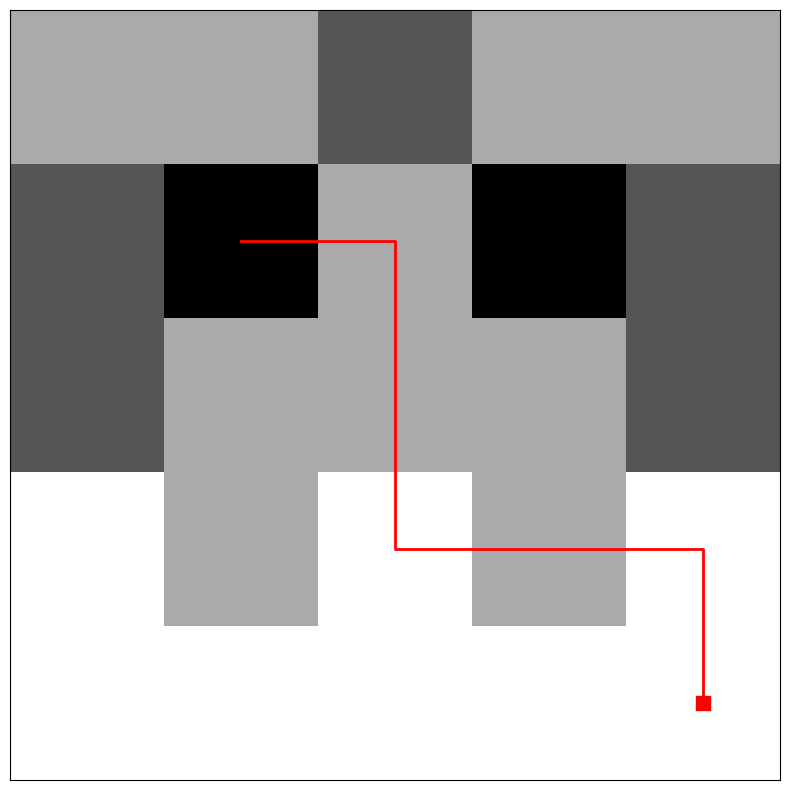

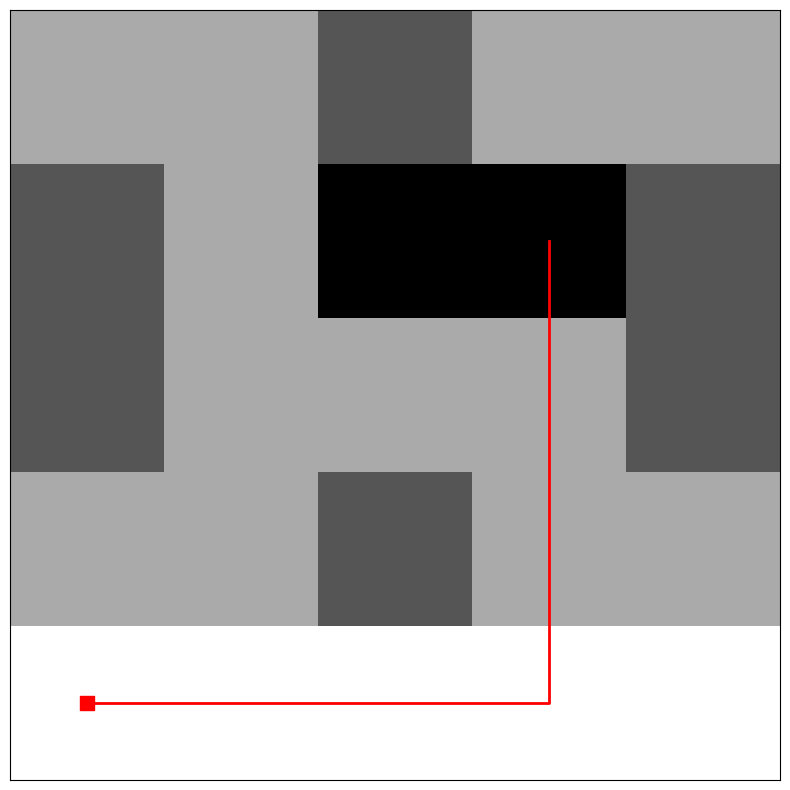

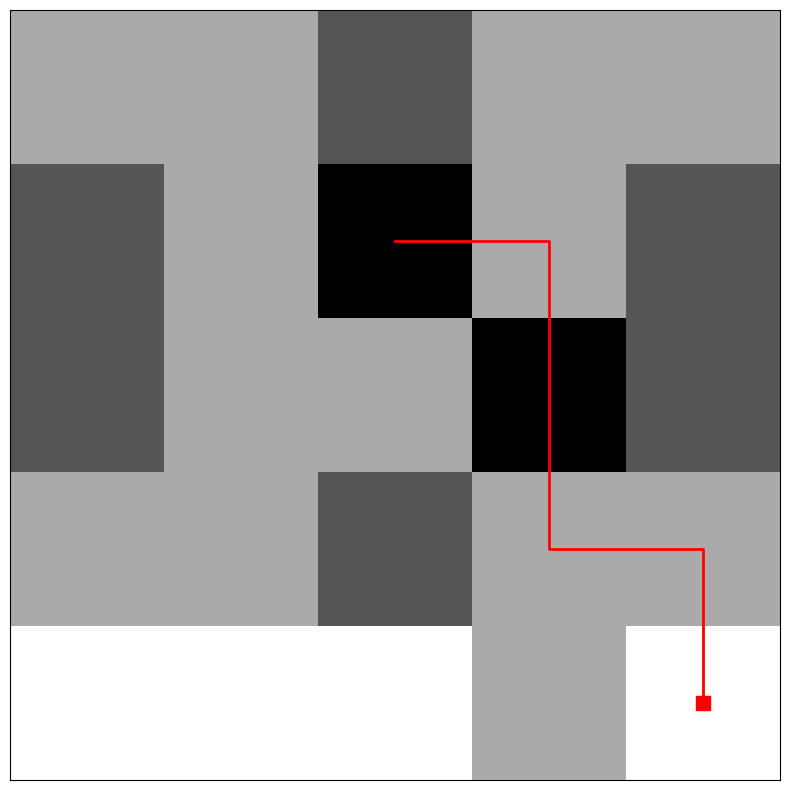

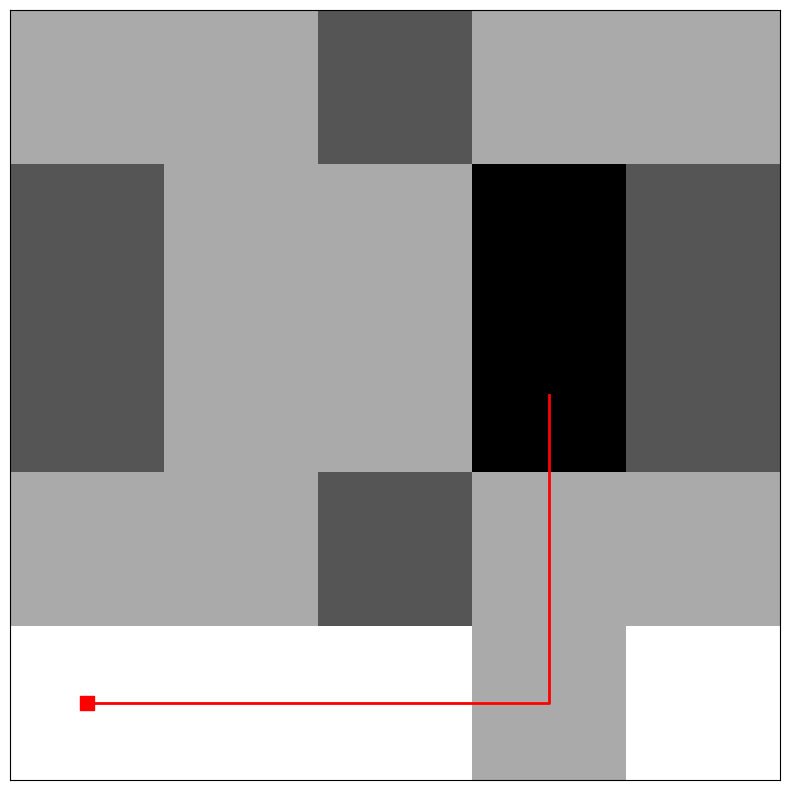

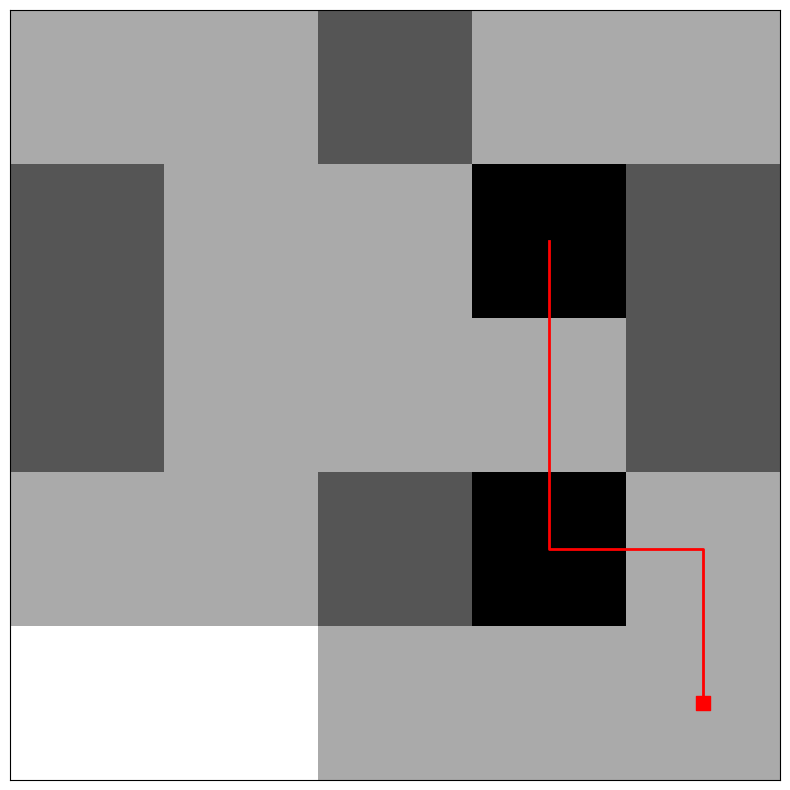

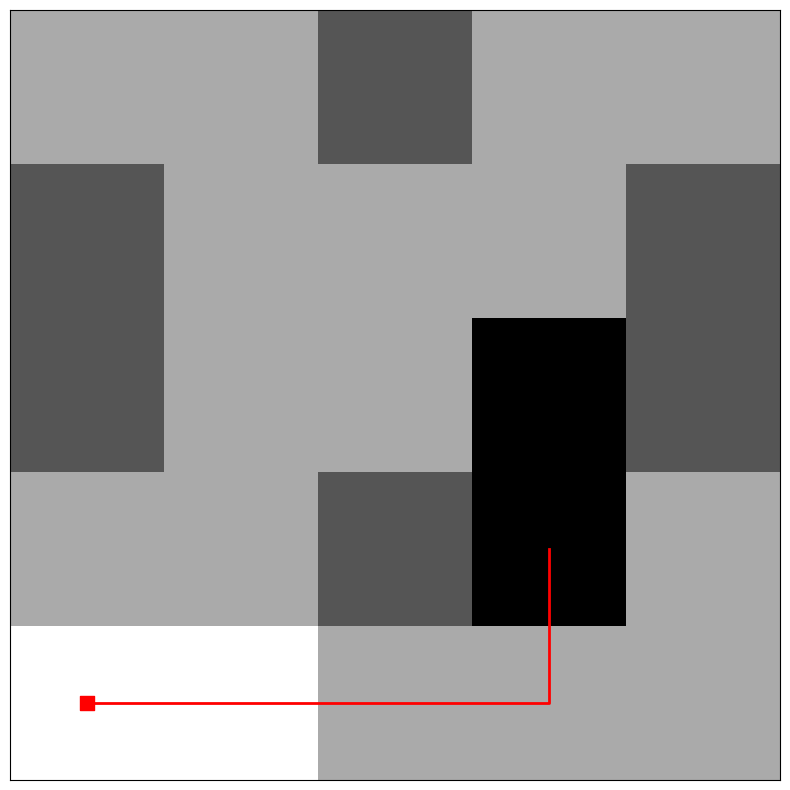

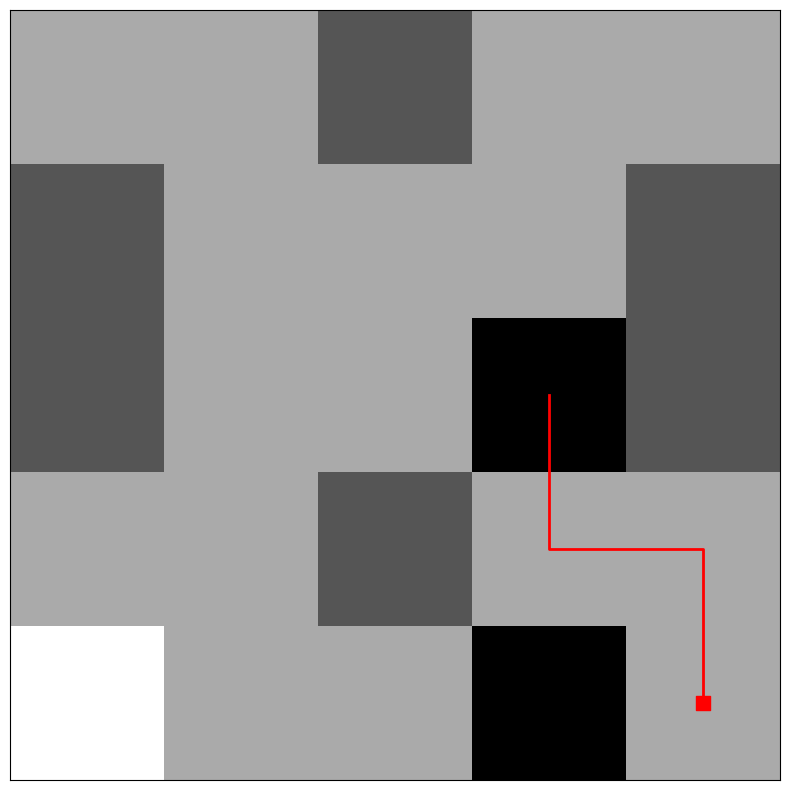

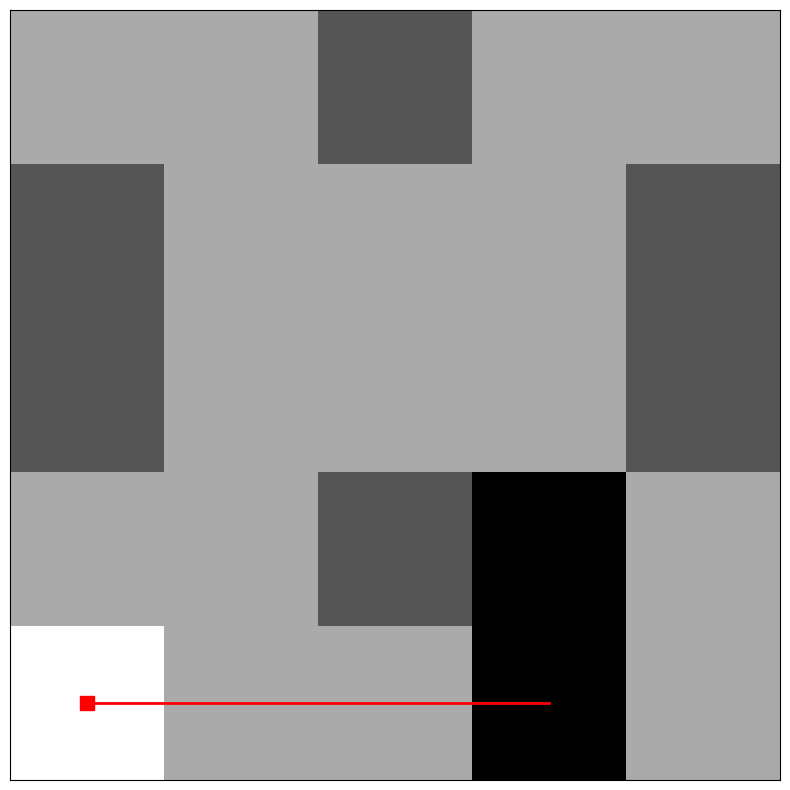

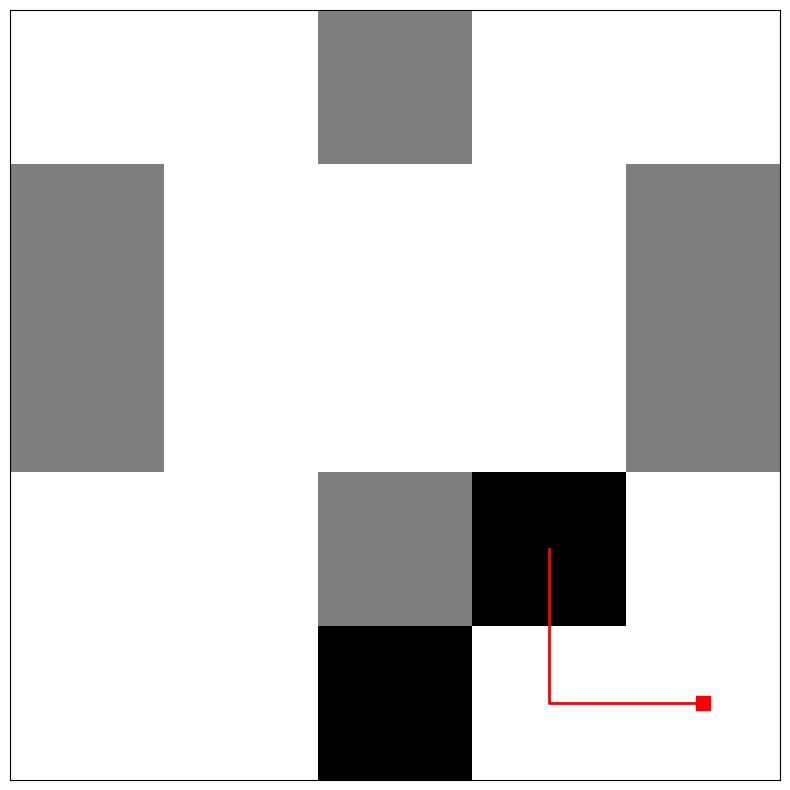

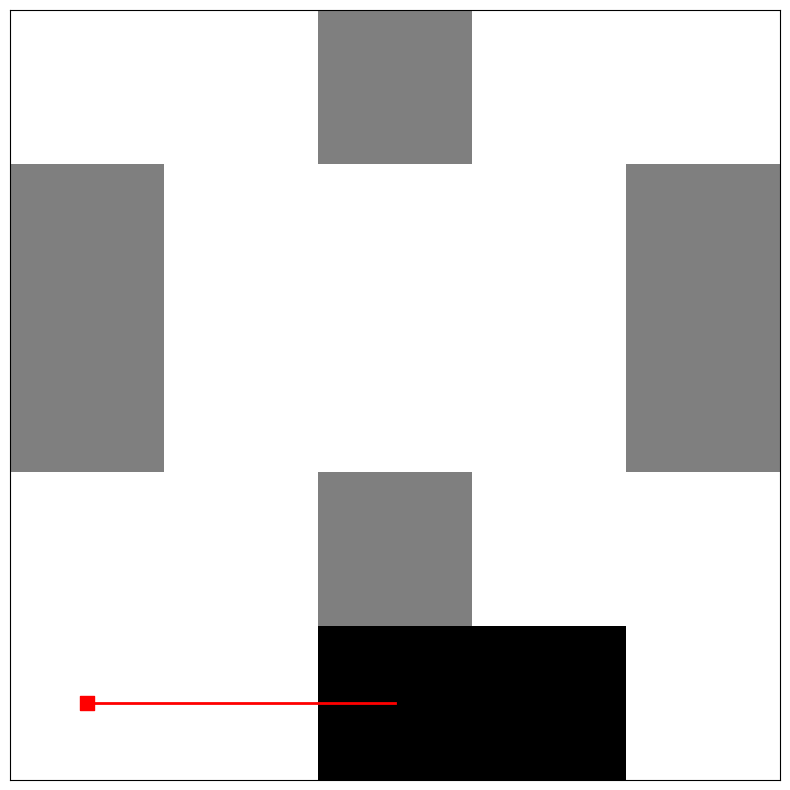

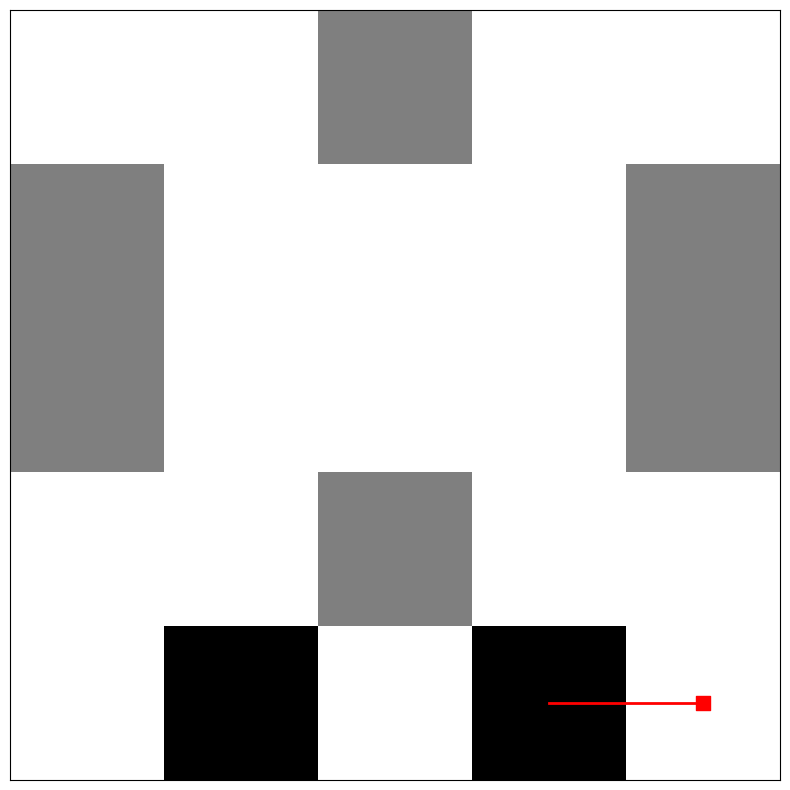

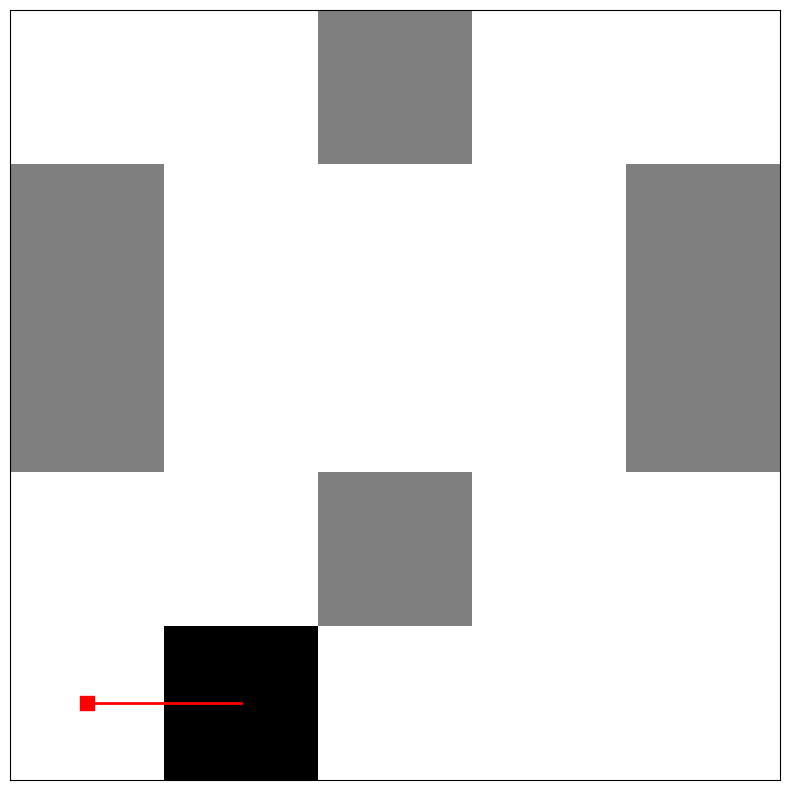

Average Coverage Percentage 1.0 / Rounds: 8 / Average Round Time: 0.39281851053237915
Final Explored Stage
[[0 0 1 0 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 0]]


In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

print("LESS OBSTACLES STAGE")
agents = [Agent((1, 1), (4, 4), grid, 2), Agent((1, 3), (4, 0), grid),]
res = move_astar(grid, agents)
print(f"Average Coverage Percentage {res[0]} / Rounds: {res[1]} / Average Round Time: {res[3]}")
print(f"Final Explored Stage\n{res[5]}")

MANY OBSTACLES STAGE


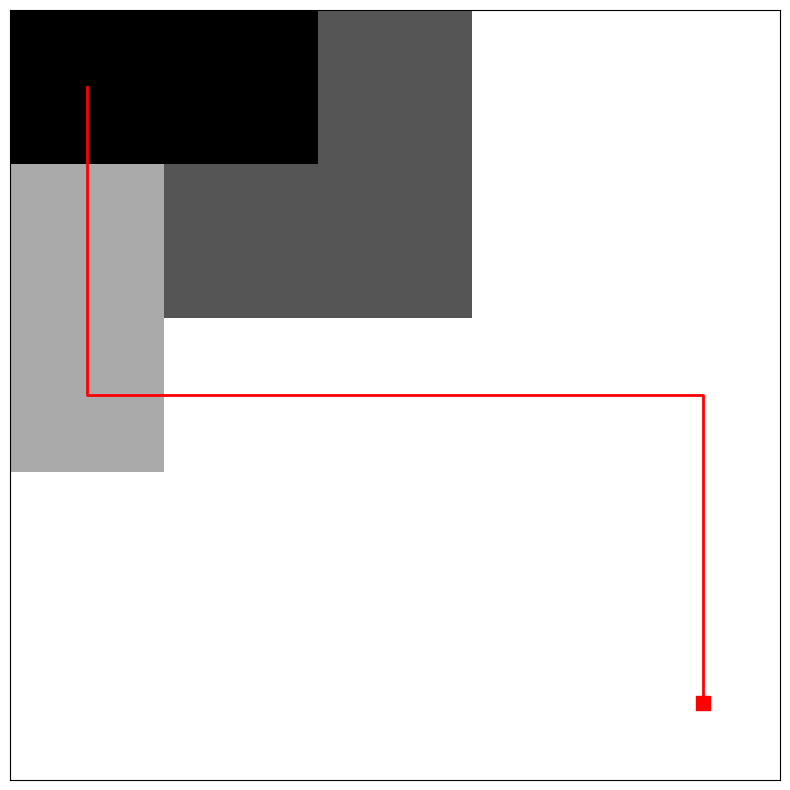

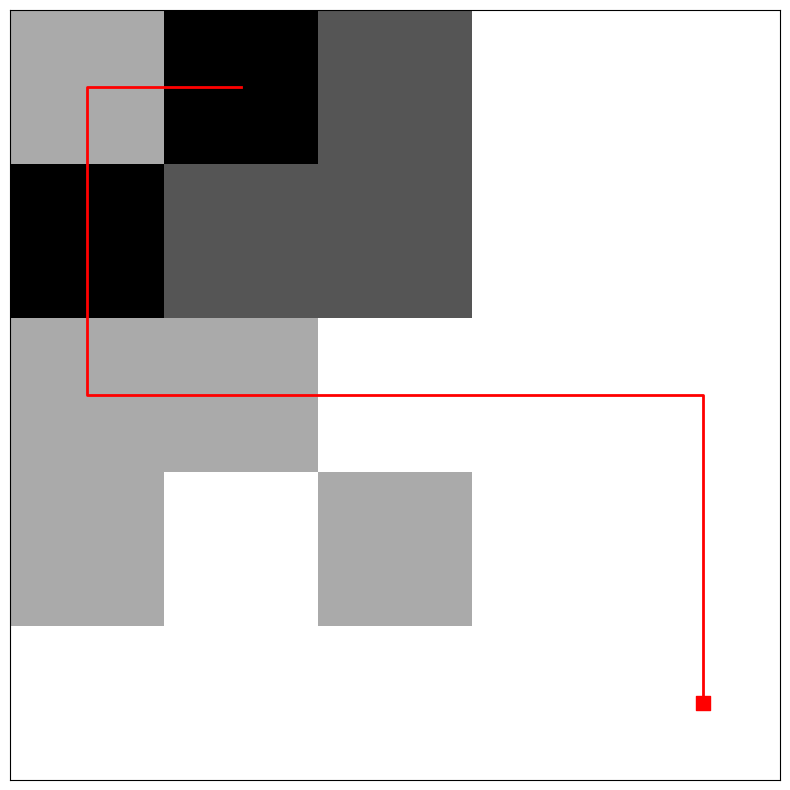

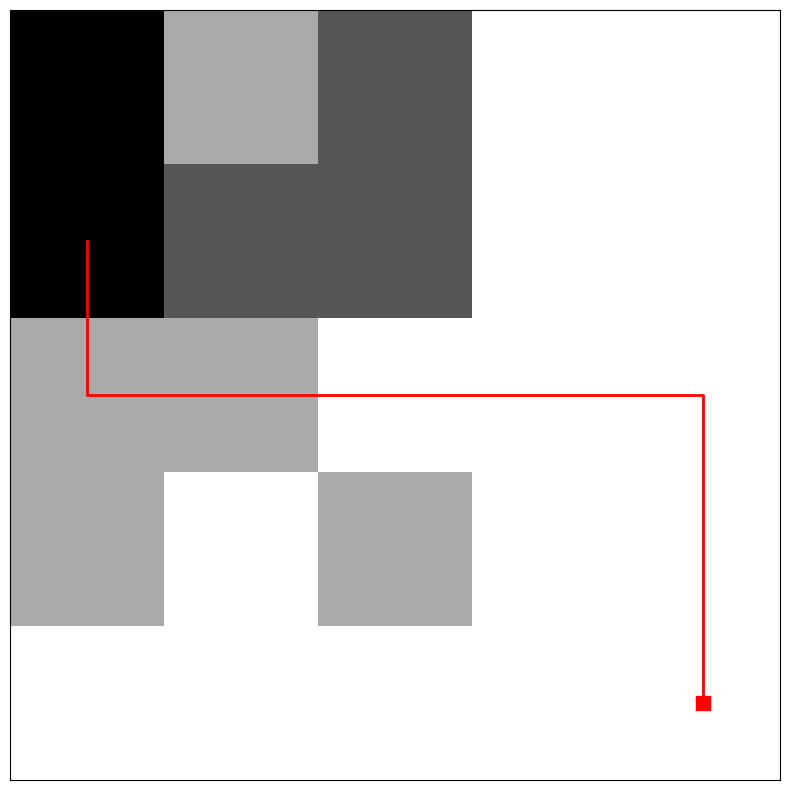

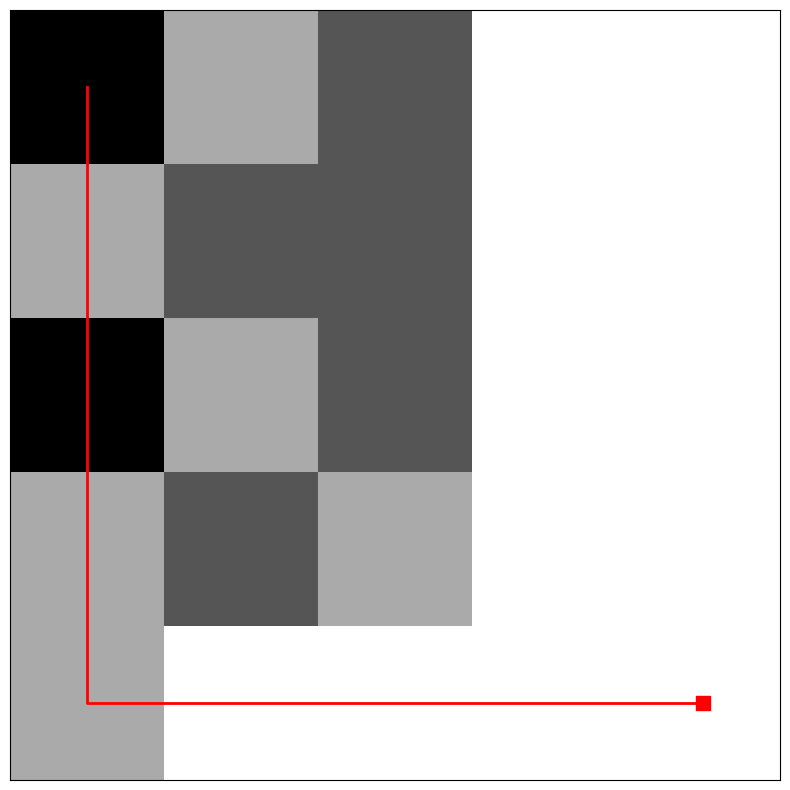

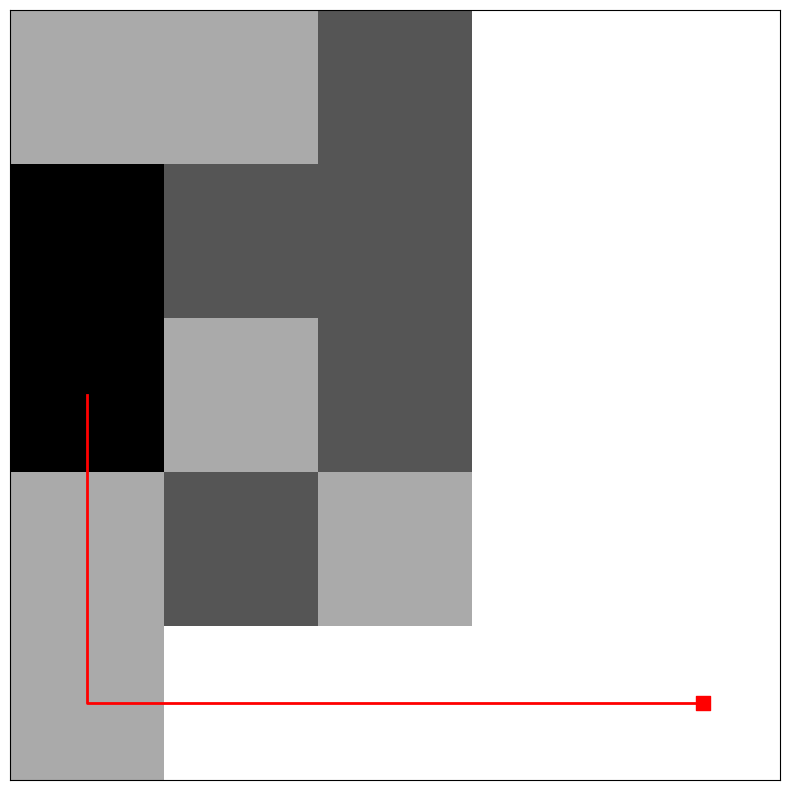

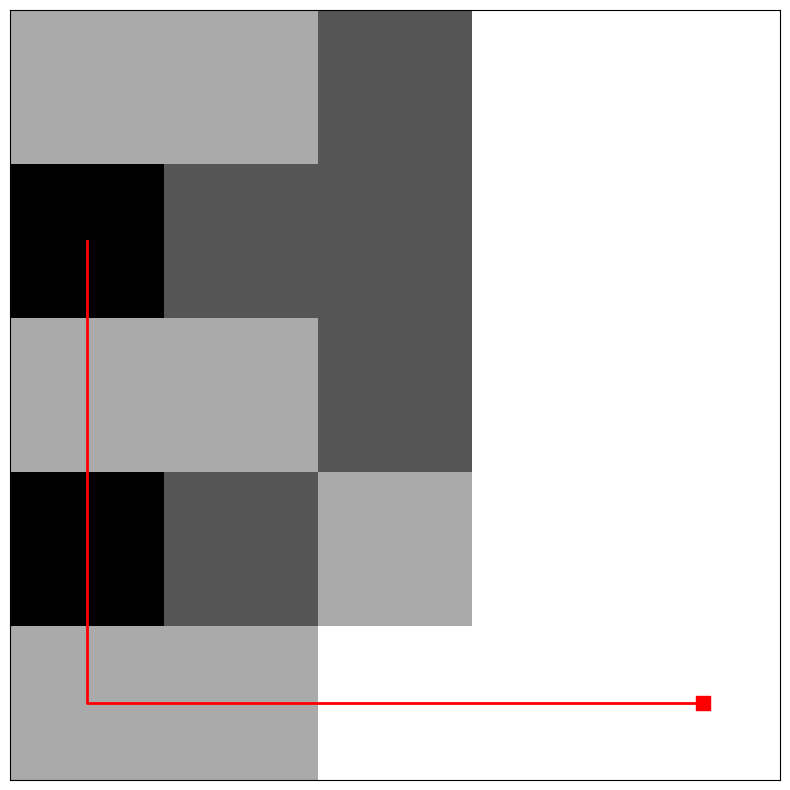

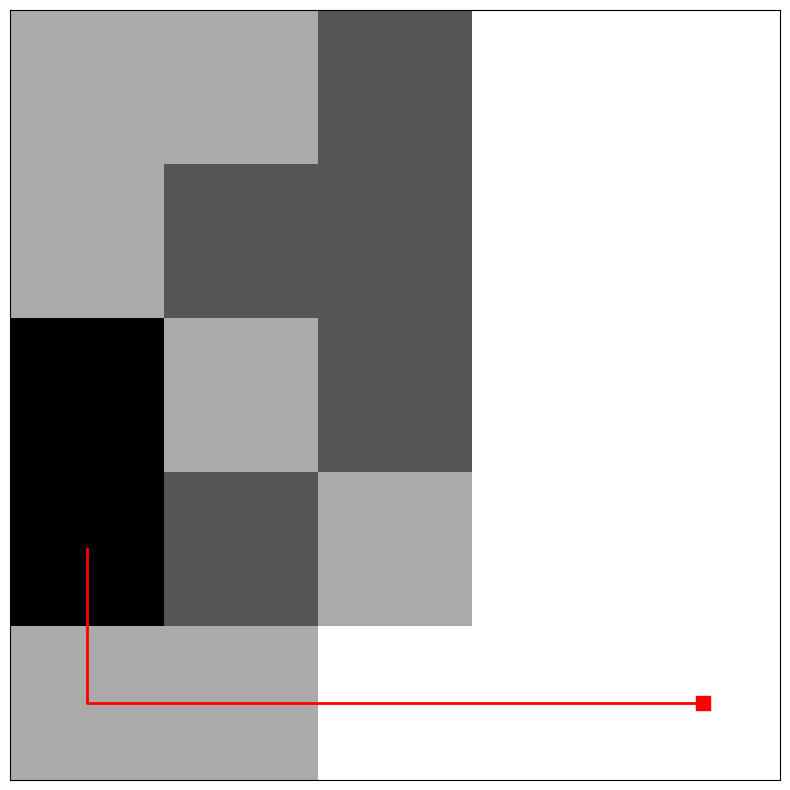

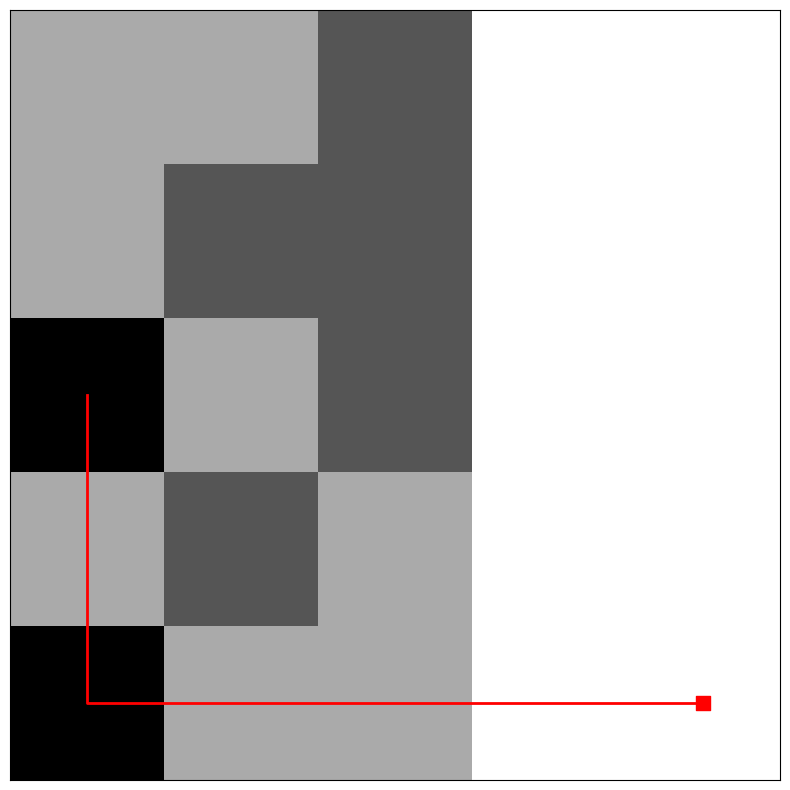

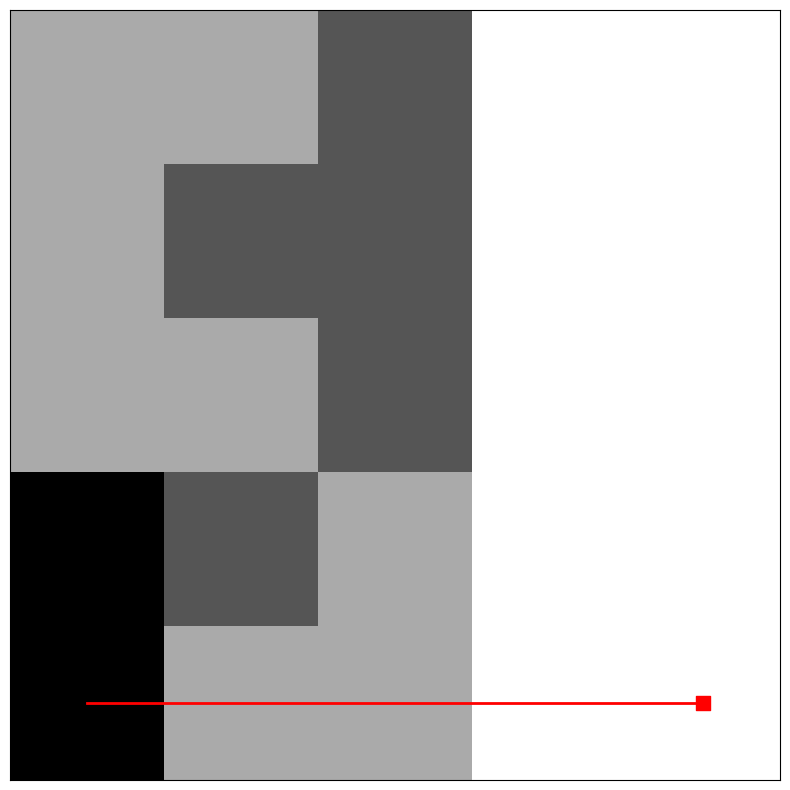

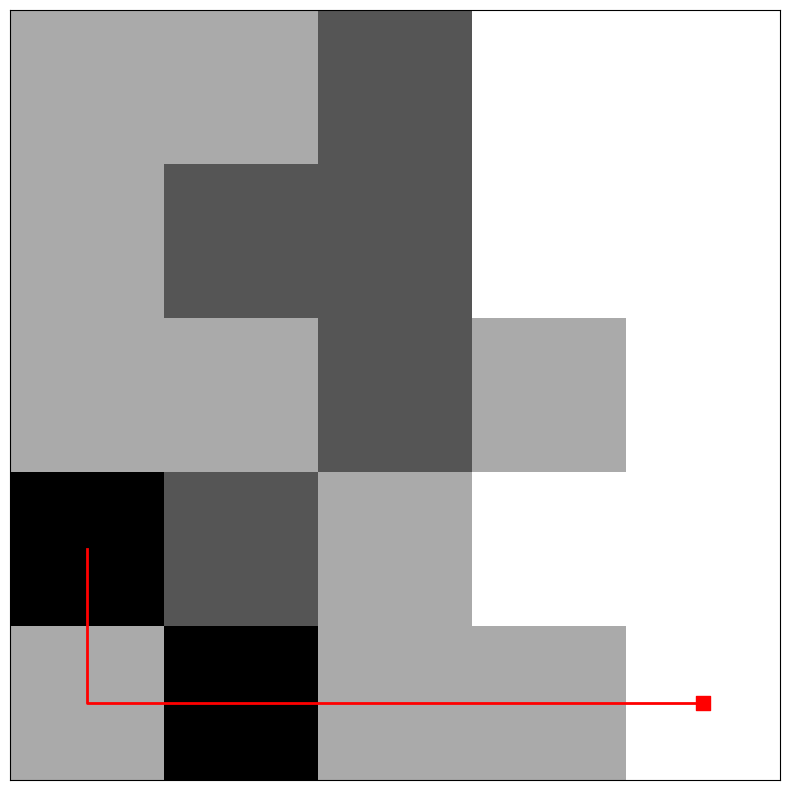

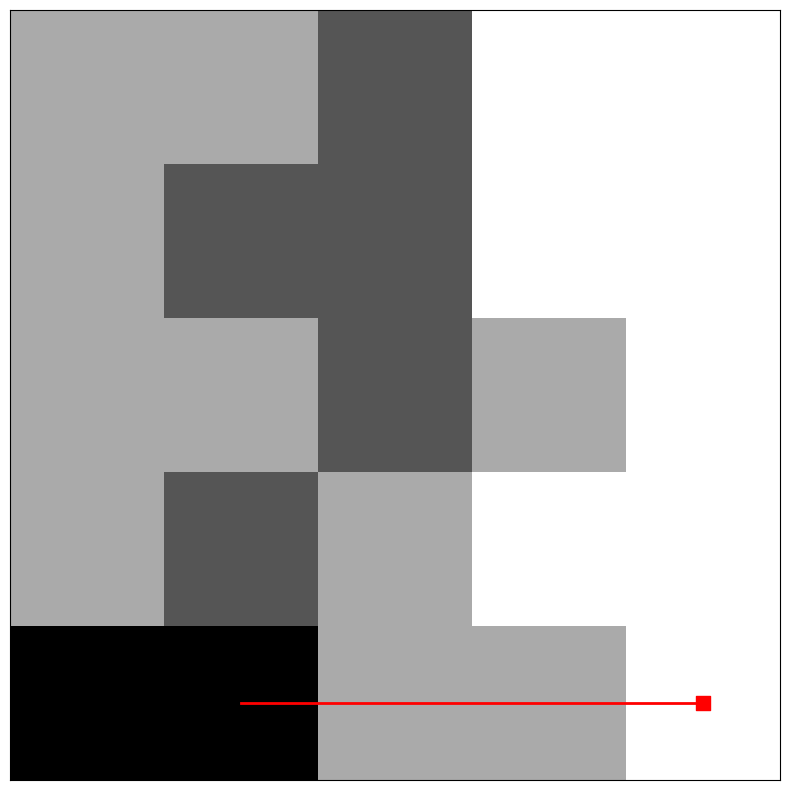

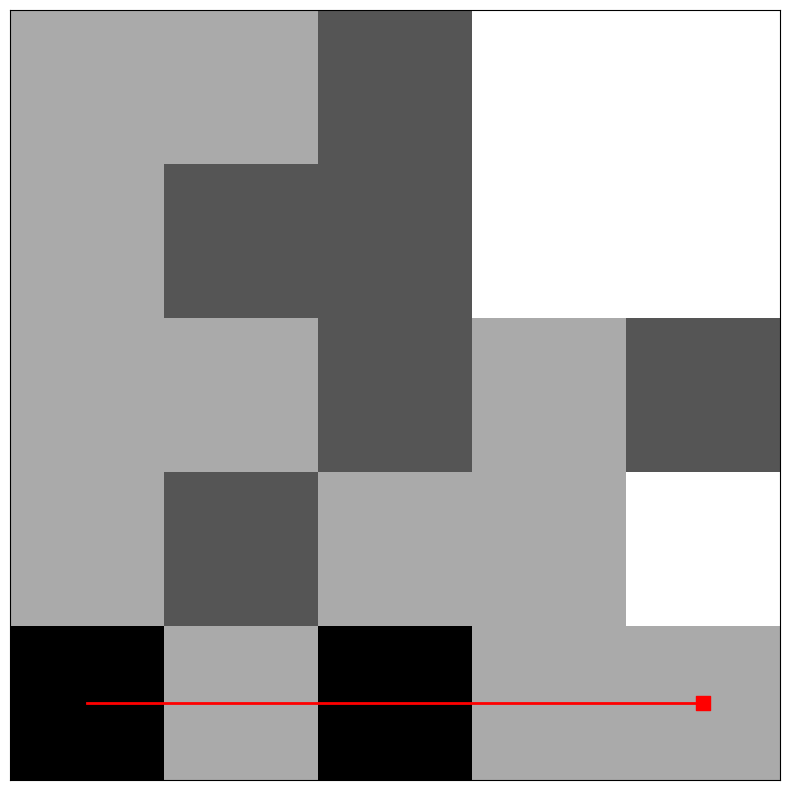

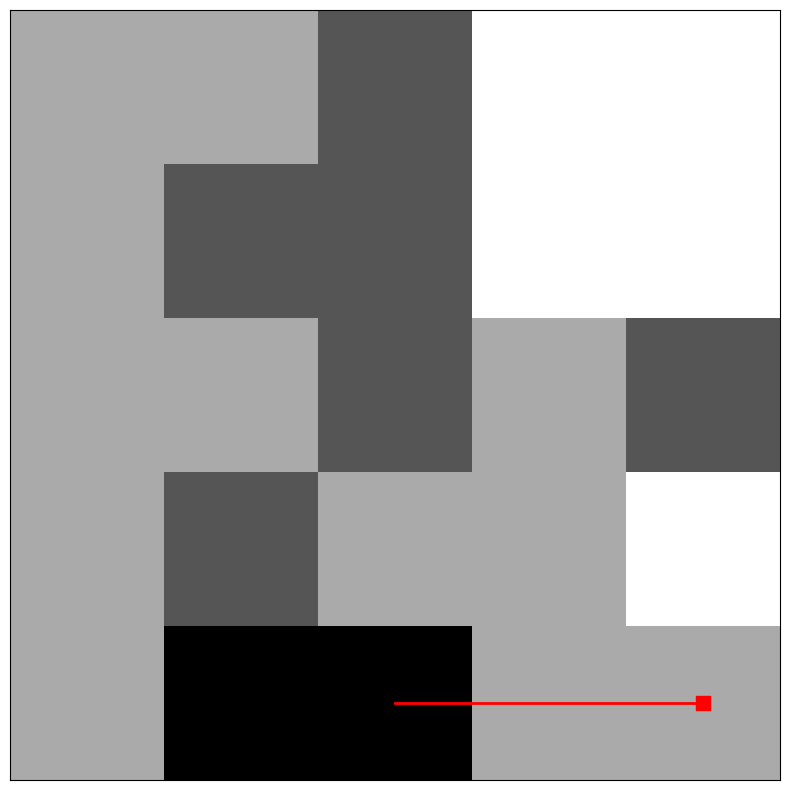

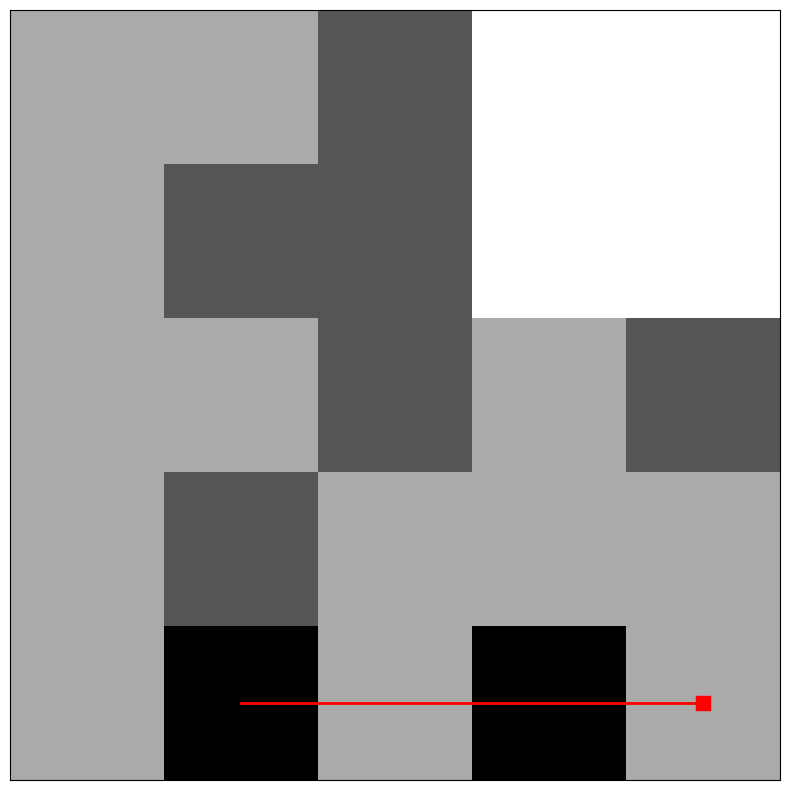

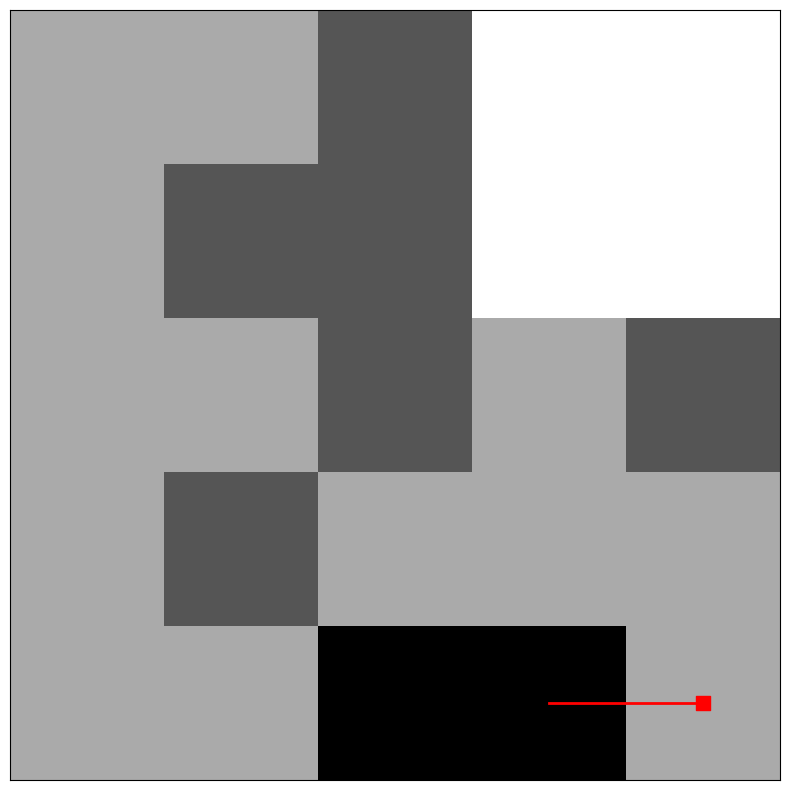

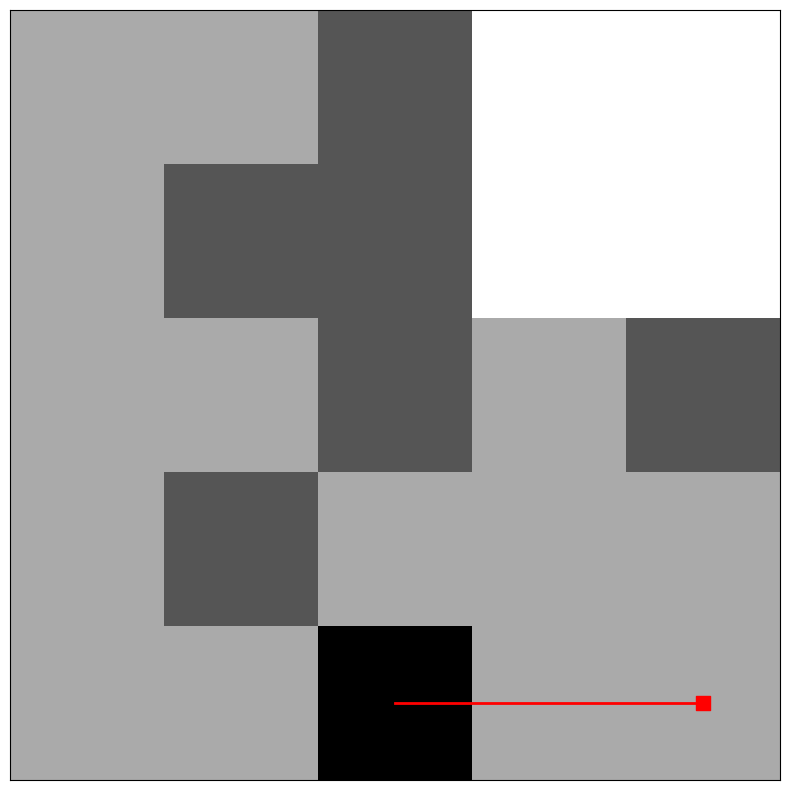

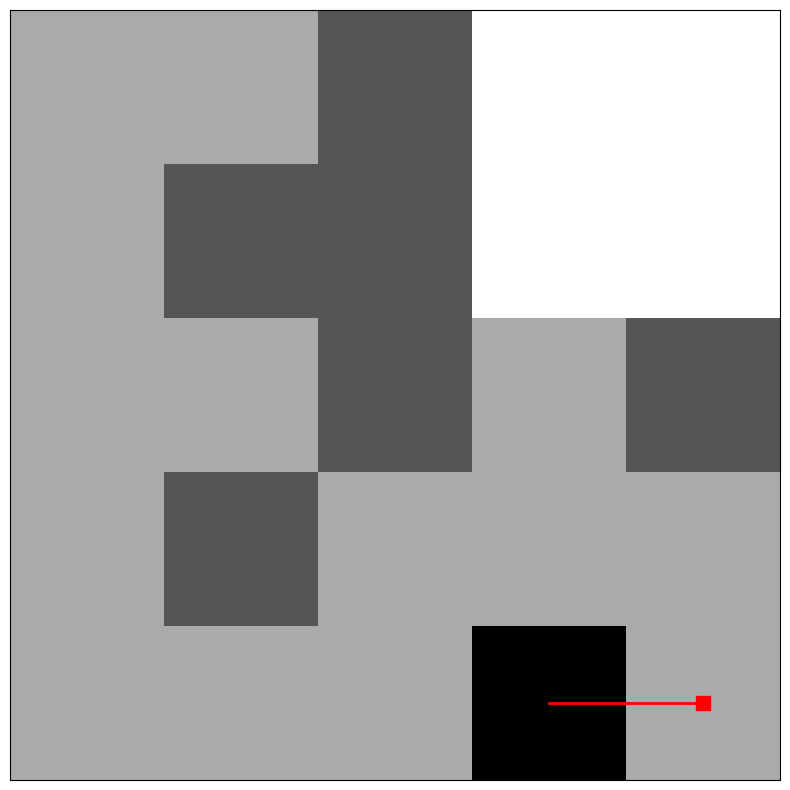

Average Coverage Percentage 0.84 / Rounds: 10 / Average Round Time: 0.3296691417694092
Final Explored Stage
[[ 0  0  1 -1 -1]
 [ 0  1  1 -1 -1]
 [ 0  0  1  0  1]
 [ 0  1  0  0  0]
 [ 0  0  0  0  0]]


In [ ]:
grid = np.array([[0, 0, 1, 1, 0],
                 [0, 0, 1, 0, 1],
                 [0, 0, 1, 0, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0]])

print("MANY OBSTACLES STAGE")
agents = [Agent((1, 1), (4, 4), grid), Agent((2, 1), (4, 4), grid)]
res = move_astar(grid, agents)
print(f"Average Coverage Percentage {res[0]} / Rounds: {res[1]} / Average Round Time: {res[3]}")
print(f"Final Explored Stage\n{res[5]}")

Function for maze creation. [Source](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96).

In [ ]:
from queue import Queue

def create_maze(rows, cols, obs_prob=0.8):
    rows = int(rows / 2)
    cols = int(cols / 2)

    maze = np.ones((rows*2+1, cols*2+1))

    x, y = (0, 0)

    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    zero_indices = np.argwhere(maze == 0)
    zero_coords = [tuple(index) for index in zero_indices]

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] # adds randomly crosses of free space.
    for z in zero_coords:
       if random.random() >= obs_prob:
          for dx, dy in directions:
            nx, ny = z[0] + dx, z[1] + dy
            maze[nx, ny] = 0

    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1
    # draw_maze(maze)
    return maze

Function to save to xlsx file:

In [ ]:
def save_xlsx(file_path: str, new_row: dict):
  """
  Saves new_row to specified xlsx file_path.
  Example of new_row dict:
    new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Finished_Agents": avg_finish,
      "Experiment_Time": avg_expt_time,
      "Episode_Time": avg_eps_time,
      "Agent_Finish_Time": avg_agent_time,
      "Dimensions": (maze_dim, maze_dim)
  }
  """

  try:
      df = pd.read_excel(file_path)
  except FileNotFoundError:
      df = pd.DataFrame(columns=[k for k in new_row.keys()])
  df = df.append(new_row, ignore_index=True)
  df.to_excel(file_path, float_format='%.5f', index=False)

Function to test astar with many experiments (print averages).

In [ ]:
def test_astar(num_agents, num_test, start_grid = None, gen_stage_func = None, file_path = None, agent_view_range = 2, debug=False, coverage_mode=False, coverage_finish=1.0):
  """
  Function to test astar with many experiments (returns averages).
  If you want to give the initial grid, initialize the variable start_grid with your grid
  (and put the gen_stage_func parameter = None).
  If you want to create a different stage for each experiment, put start_grid = None
  and initialize the next parameter (gen_stage_func) like so:
  functools.partial(func_for_grid_gen, rows, cols, obs_prob)
  where func_for_grid_gen is a function for grid generation, rows and cols are the number
  of rows and columns of the grid and obs_prob the probablity of obstacles.
  """
  avg_cover = []
  avg_rounds = []
  avg_exp_time = []
  avg_round_time= []
  avg_agent_step_time = []

  params = gen_stage_func.keywords

  count_false = 0

  for i in range(num_test):
    if count_false > 4:
      break

    print(f"Test: {i}")
    start_time = time.time()
    if start_grid is None:
      grid = gen_stage_func()
    else:
      grid = copy.deepcopy(start_grid)
    agents = generate_agents(real_stage = grid, num_agents = num_agents, view_range = agent_view_range, coverage_mode = coverage_mode)
    if coverage_mode:
      res = move_astar_coverage(start_grid=grid, start_agents=agents, coverage_finish = coverage_finish, debug=debug)
      if res[4] != 0:
        count_false += 1
      if file_path is not None:
        save_xlsx(file_path, {"#_Agents":num_agents, "Coverage": res[0], "Rounds": res[1], "Avg_Round_Time": res[3], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": time.time()-start_time, "Obs_Prob": params["obs_prob"], "Test": i})
    else:
      res = move_astar(start_grid=grid, start_agents=agents, debug=debug)
      if file_path is not None:
        save_xlsx(file_path, {"#_Agents":num_agents, "Coverage": res[0], "Rounds": res[1], "Avg_Rounds": res[2], "Avg_Round_Time": res[3], "Finished_Agents": res[4], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": time.time()-start_time, "Obs_Prob": params["obs_prob"], "Test": i})
    avg_cover.append(res[0])
    avg_rounds.append(res[1])
    avg_exp_time.append(time.time() - start_time)
    avg_round_time.append(res[3])
    avg_agent_step_time.append(res[3]/num_agents)
    # if res[0] != 1:
    #   draw_maze(res[2])

  avg_cover, avg_rounds, avg_exp_time, avg_round_time, avg_agent_step_time = np.mean(avg_cover), np.mean(avg_rounds), np.mean(avg_exp_time), np.mean(avg_round_time), np.mean(avg_agent_step_time)
  if coverage_mode:
    print(f"Average Coverage Percentage: {avg_cover} / Average Rounds: {avg_rounds} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
  else:
    print(f"Average Coverage Percentage: {avg_cover} / Average Rounds: {avg_rounds} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
  return avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time

Testing with dynamically generated stages/mazes:

In [ ]:
num_agents = 10 # number of agents.
num_test = 10
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=10, cols=10, obs_prob=0.85), debug=False, file_path="/content/drive/My Drive/thesis/xlsx/astar_swarm_test.xlsx")
# res=test_astar(num_agents, num_test, None, functools.partial(generate_stage, rows=10, cols=10, obs_prob=0.5), debug=True)

In [ ]:
num_agents = 10 # number of agents.
num_test = 300
res=test_astar(num_agents, num_test, None, functools.partial(create_maze, rows=30, cols=30, obs_prob=0.85), debug=False, coverage_mode=True, file_path=None)

Average results of running 100 experiments of coverage_mode with 100 % threshold:<br>
`Average Coverage Percentage: 0.9994216253308498 / Average Finished: 0.0 / Average Experiment Time: 684.6852569580078s / Average Episode Time: 0.687087503360617 / Average Agent Finish Time : nan`

Save experiments on a xlsx file:

In [ ]:
# Initialization Parameters ========
min_num_agents = 10
max_num_agents = 10
rows = 30
cols = 30
obs_prob = 0.85
num_test = 5
agent_view = 2
coverage_mode = False
# =================================

file_path_all = f'/content/drive/My Drive/thesis/xlsx/astar_swarm_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
file_path = f'/content/drive/My Drive/thesis/xlsx/astar_swarm_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'  # saves the averages.


for num_agent in range(min_num_agents, max_num_agents + 1):
  print(f"Agent number: {num_agent}")
  avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob=obs_prob), agent_view_range=agent_view, debug=False, file_path=file_path_all, coverage_mode=coverage_mode)
  new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Avg_Rounds": avg_rounds,
      "Avg_Round_Time": avg_round_time,
      "Avg_Agent_Step_Time": avg_agent_step_time,
      "Experiment_Time": avg_exp_time,
      "Obs_Prob": obs_prob,
  }
  save_xlsx(file_path, new_row) # saves averages.



Agent number: 10
Test: 0
Test: 1
Test: 2
Test: 3
Test: 4
Average Coverage Percentage: 1.0 / Average Rounds: 38.4 / Average Round Time: 0.06449218693563832 / Average Agent Step Time: 0.006449218693563833 / Average Experiment Time: 2.545106315612793


In [ ]:
file_path = '/content/drive/My Drive/thesis/xlsx/astar_swarm_all_30x30_True_2.xlsx'
df = pd.read_excel(file_path)

print(df['R=E'].mean())


# first 50 -> manhattan python function
first_50 = df.head(50)
print(first_50['Rounds'].mean())

# last 50 -> manhattan scipy function
last_50 = df.tail(50)
print(last_50['Rounds'].mean())


0.0
68.3
68.1


(to sort the df, use `df = df.sort_values(by=['#_Agents', 'Dimensions'])`

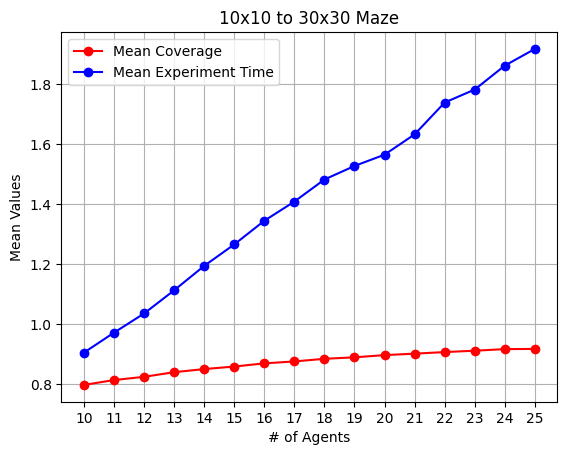

In [ ]:
file_path = '/content/drive/My Drive/astar_swarm.xlsx'
df = pd.read_excel(file_path).groupby('#_Agents').mean().reset_index()

plt.plot(df['#_Agents'], df['Coverage'], color='red', label='Mean Coverage', marker='o')
plt.plot(df['#_Agents'], df['Experiment_Time'], color='blue', label='Mean Experiment Time', marker='o')

plt.title("10x10 to 30x30 Maze")
plt.xlabel('# of Agents')
plt.ylabel('Mean Values')
plt.legend()
plt.xticks(df['#_Agents'].astype(int))
plt.grid(True)
plt.show()

Testing 100 times for maze 100x200 for agents 10 -> 25:

In [ ]:
file_path = '/content/drive/My Drive/astar_swarm100x200.xlsx'

# Initialization Parameters ========
min_num_agents = 10
max_num_agents = 25
rows = 100
cols = 200
num_test = 10
obs_prob = 0.15
# =================================

try:
    df = pd.read_excel(file_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["#_Agents", "Coverage", "Finished_Agents", "Experiment_Time", "Episode_Time", "Agent_Finish_Time", "Dimensions", "Obs_Prob"])

for num_agent in range(min_num_agents, max_num_agents + 1):
  print(f"Agent number: {num_agent}")
  print(f"  Obs_Prob: {obs_prob}")
  avg_cover, avg_finish, avg_expt_time, avg_eps_time, avg_agent_time = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob=obs_prob), agent_view_range=200, debug=False)
  new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Finished_Agents": avg_finish,
      "Experiment_Time": avg_expt_time,
      "Episode_Time": avg_eps_time,
      "Agent_Finish_Time": avg_agent_time,
      "Dimensions": (rows, cols),
      "Obs_Prob": obs_prob
  }
  df = df.append(new_row, ignore_index=True)
  df.to_excel(file_path, float_format='%.5f', index=False)
  print(f"    Obs_Prob: {1-obs_prob}")

  avg_cover, avg_finish, avg_expt_time, avg_eps_time, avg_agent_time = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob=1-obs_prob), agent_view_range=200, debug=False)
  new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Finished_Agents": avg_finish,
      "Experiment_Time": avg_expt_time,
      "Episode_Time": avg_eps_time,
      "Agent_Finish_Time": avg_agent_time,
      "Dimensions": (rows, cols),
      "Obs_Prob": 1 - obs_prob
  }
  df = df.append(new_row, ignore_index=True)
  df.to_excel(file_path, float_format='%.5f', index=False)

Agent number: 10
  Obs_Prob: 0.15
   Test: 0
   Test: 1
   Test: 2
   Test: 3
   Test: 4
   Test: 5
   Test: 6
   Test: 7
   Test: 8
   Test: 9


Plot the results of 100x200 (you can see the xlsx [here](https://docs.google.com/spreadsheets/d/1Pwe-wLCWv56M7RLzK7HB2BBoIg36Njn8/edit?usp=sharing&ouid=107246824104571234611&rtpof=true&sd=true)).

Mean agent step time is just the mean episode time divived by the number of agents.

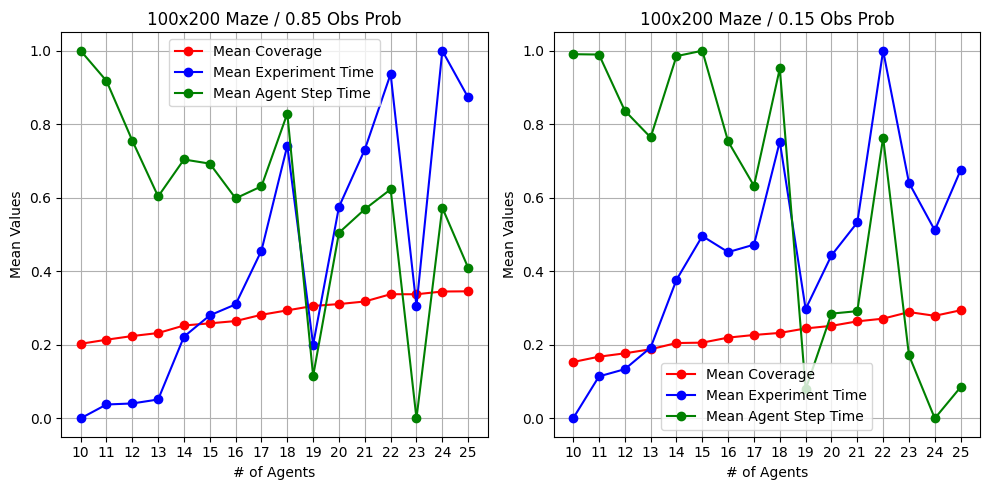

In [ ]:
file_path = '/content/drive/My Drive/astar_swarm100x200.xlsx'
df = pd.read_excel(file_path)

filtered_df_085 = df[df['Obs_Prob'] == 0.85]
filtered_df_015 = df[df['Obs_Prob'] == 0.15]

scaler = MinMaxScaler()
df_normalized_085 = pd.DataFrame(scaler.fit_transform(filtered_df_085[['Experiment_Time', 'Agent_Step_Time']]), columns=['Experiment_Time', 'Agent_Step_Time'])
df_normalized_015 = pd.DataFrame(scaler.fit_transform(filtered_df_015[['Experiment_Time', 'Agent_Step_Time']]), columns=['Experiment_Time', 'Agent_Step_Time'])

# Plotting for obs_prob == 0.85
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(filtered_df_085['#_Agents'], filtered_df_085['Coverage'], color='red', label='Mean Coverage', marker='o')
plt.plot(filtered_df_085['#_Agents'], df_normalized_085['Experiment_Time'], color='blue', label='Mean Experiment Time', marker='o')
plt.plot(filtered_df_085['#_Agents'], df_normalized_085['Agent_Step_Time'], color='green', label='Mean Agent Step Time', marker='o')

plt.title("100x200 Maze / 0.85 Obs Prob")
plt.xlabel('# of Agents')
plt.ylabel('Mean Values')
plt.legend()
plt.xticks(filtered_df_085['#_Agents'].astype(int))
plt.grid(True)

# Plotting for obs_prob == 0.15
plt.subplot(1, 2, 2)
plt.plot(filtered_df_015['#_Agents'], filtered_df_015['Coverage'], color='red', label='Mean Coverage', marker='o')
plt.plot(filtered_df_015['#_Agents'], df_normalized_015['Experiment_Time'], color='blue', label='Mean Experiment Time', marker='o')
plt.plot(filtered_df_015['#_Agents'], df_normalized_015['Agent_Step_Time'], color='green', label='Mean Agent Step Time', marker='o')


plt.title("100x200 Maze / 0.15 Obs Prob")
plt.xlabel('# of Agents')
plt.ylabel('Mean Values')
plt.legend()
plt.xticks(filtered_df_015['#_Agents'].astype(int))
plt.grid(True)

plt.tight_layout()
plt.show()

Check agent view:

In [ ]:
grid = np.array([[0, 0, 1, 0, 0],
                 [1, 0, 0, 2, 1],
                 [1, 0, 0, 1, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0]])

agents = [Agent((2, 2), (2, 2), grid, 2),]
res = move_astar(grid, agents)


[[ 0 -1  1 -1 -1]
 [-1  0  0  0 -1]
 [ 1  0  0  1 -1]
 [-1  0  1  0 -1]
 [ 0 -1 -1 -1  0]]


In [ ]:

import numpy as np

agent_pos = (0, 1)
total_explored = np.array([[0, 1, 0], [1, -1, -1], [0, -1, -1]])  # Example array
print(total_explored)
n_rows, n_cols = total_explored.shape
x_coords, y_coords = np.meshgrid(np.arange(n_rows), np.arange(n_cols))
distances = np.abs(x_coords - agent_pos[0]) + np.abs(y_coords - agent_pos[1])

print(distances)
# distances[(total_explored != -1)] = max(total_explored.shape) + 1
# indx = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
# print(distances)
# print(indx)
# print(total_explored[indx])


# Mask the non-target cells by setting their distances to a high value
distances[total_explored != -1] = max(total_explored.shape) + 1
print(distances)
# Get the indices that would sort the distances
flat_indices = np.argsort(distances, axis=None)

# Convert flat indices to 2D indices
min_indices = np.unravel_index(flat_indices, distances.shape)

# Convert indices to a list of tuples in the desired order
indx = list(zip(min_indices[0], min_indices[1]))
print(indx)


[[ 0  1  0]
 [ 1 -1 -1]
 [ 0 -1 -1]]
[[1 2 3]
 [0 1 2]
 [1 2 3]]
[[4 4 4]
 [4 1 2]
 [4 2 3]]
[(1, 1), (1, 2), (2, 1), (2, 2), (0, 0), (0, 1), (0, 2), (1, 0), (2, 0)]
[[1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]


array([[2., 3., 2., 3., 4.]])